## Problem Statement:

### RBI Cash demand forecasting using time series.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pandas import datetime
from sklearn.metrics import mean_squared_error

C:\Users\jkfra\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


In [2]:
df= pd.read_excel('RBI.xlsx')
df['Date']= pd.to_datetime(df['Date'])

In [3]:
df.set_index('Date', inplace=True)

In [4]:
df.head()

,Value
Date,
2020-06-01,4764.812000
2020-06-02,4781.974663
2020-06-03,4426.915552
2020-06-04,4424.531824
2020-06-05,4321.009311


In [5]:
df.tail()

,Value
Date,
2020-09-25,3595.76
2020-09-26,3760.84
2020-09-27,2878.27
2020-09-28,3848.13
2020-09-29,3915.17


In [6]:
df.describe()


,Value
count,121.000000
mean,3947.881588
std,702.683669
min,1990.820000
25%,3595.760000
50%,3984.090000
75%,4476.890000
max,5165.170000


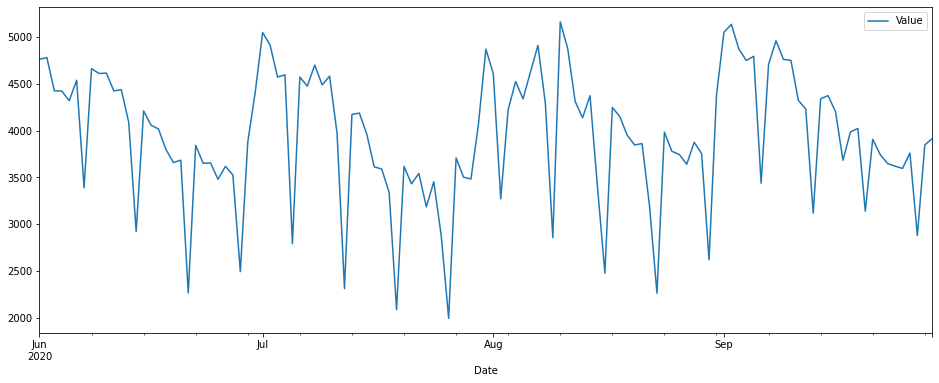

In [7]:
#Plotting the original data
df.plot(kind= 'line', figsize=(16,6))
plt.show()

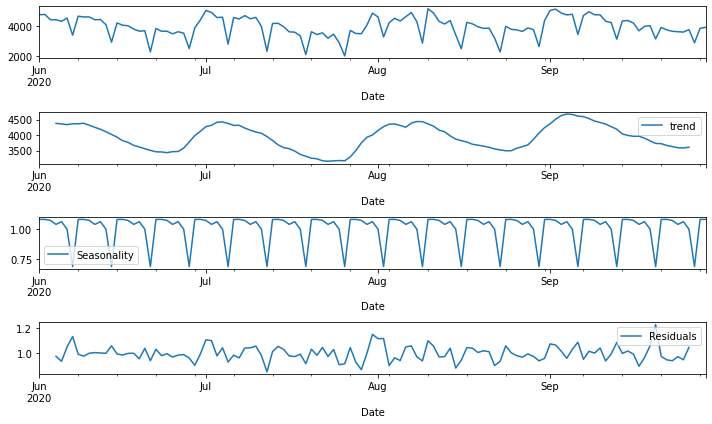

In [8]:
#Decomposing to check the seasonality, trend and residuals

df1 = df['Value']
import statsmodels.tsa.seasonal as sts
decomposition = sts.seasonal_decompose(df1,model='multiplicative', period=7) #freq

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
df1.plot(kind="line",figsize=(10,6),label='Original')
plt.subplot(412)
trend.plot(kind="line",figsize=(10,6),label='trend')
plt.legend(loc='best')
plt.subplot(413)
seasonal.plot(kind="line",figsize=(10,6),label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
residual.plot(kind="line",figsize=(10,6),label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Here we can see dual seasonality i.e, we have weekly as well as monthly seasonality. However, we see a overall constant trend.

In [9]:
# Testing For Stationarity using Dickeyfuller Test

from statsmodels.tsa.stattools import adfuller

In [10]:
stationarity_test= adfuller(df)

In [11]:
stationarity_test

(-5.198570901268634,
 8.851341293954471e-06,
 10,
 110,
 {'1%': -3.4912451337340342,
  '5%': -2.8881954545454547,
  '10%': -2.5809876033057852},
 1552.6727754931476)

In [12]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(value):
    result=adfuller(value)
    labels = ['ADF Test Statistic','p-value','Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+ str(value) )
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("Weak evidence against null hypothesis, indicating it is non-stationary ")

In [13]:
adfuller_test(df)

ADF Test Statistic : -5.198570901268634
p-value : 8.851341293954471e-06
Lags Used : 10
Number of Observations Used : 110
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [14]:
#Plotting ACF and PACF to get the value of parameter p and q
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

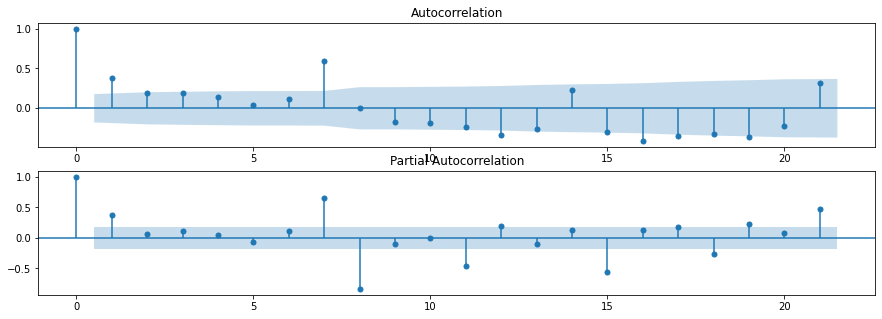

In [15]:
fig= plt.figure(figsize=(15,5))
ax1= fig.add_subplot(211)
fig= sm.graphics.tsa.plot_acf(df['Value'], ax= ax1)
ax2= fig.add_subplot(212)
fig= sm.graphics.tsa.plot_pacf(df['Value'], ax= ax2)
plt.show()

In [16]:
df.shape

(121, 1)

In [17]:
print(10)

10


In [18]:
#Splitting data into train and test
train= df['Value'][0:107]
test= df['Value'][107:]

# Model 1

#### Moving Average Method

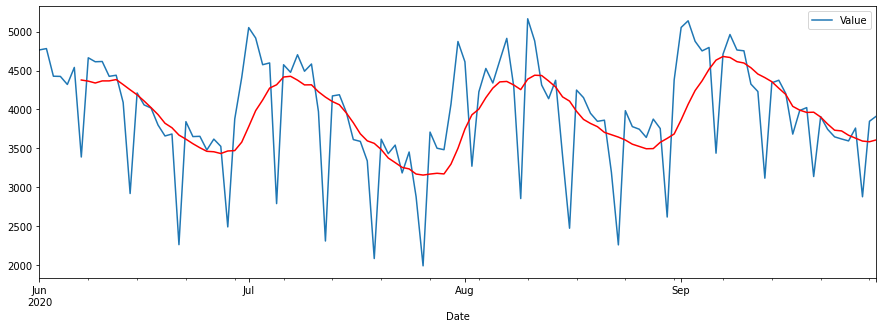

In [19]:
time1 = df['Value']
moving_avg =time1.rolling(7).mean()
df.plot(kind="line",figsize=(15,5))
moving_avg.plot(kind="line",figsize=(15,5),color='red')
plt.show()

In [20]:
forecast_1= moving_avg.tail(14)
print('RMSE : ', np.sqrt(mean_squared_error(test, forecast_1)))

RMSE :  330.9492233231884


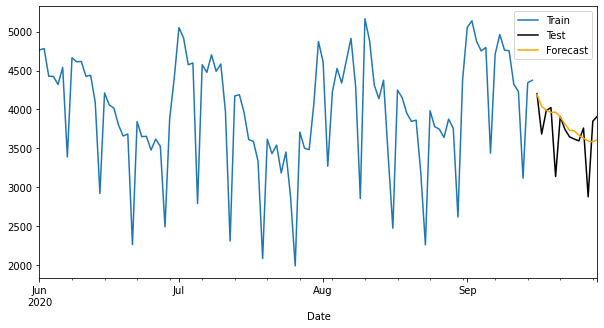

In [21]:
train.plot(kind="line",figsize=(10,5),legend=True, label='Train')
test.plot(kind="line",figsize=(10,5),legend=True, color='black', label='Test')
forecast_1.plot(kind="line",figsize=(10,5),color='orange',legend=True,label='Forecast')
plt.show()

# Model 2

#### SARIMAX (1,0,1), (1,0,1,7)

In [22]:
# Here the data is stationary and has seasonality so I have applied Seasonal ARIMA model,
#I have taken the value of parameter based on the plotted ACF and PACF graph.

In [23]:
model_2= sm.tsa.statespace.SARIMAX(train, order= (1, 0, 1),seasonal_order= (1, 0, 1, 7))
model_2= model_2.fit()

C:\Users\jkfra\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\jkfra\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\jkfra\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [24]:
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Value   No. Observations:                  107
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood                -772.899
Date:                           Mon, 31 May 2021   AIC                           1555.798
Time:                                   11:30:25   BIC                           1569.162
Sample:                               06-01-2020   HQIC                          1561.216
                                    - 09-15-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8959      0.050     17.830      0.000       0.797       0.994
ma.L1         -0.0730      0.100     -0.732      0.464      -0.269       0.123
ar.S.L7        0.9992      0.002    617.056      0.000       0.996       1.002
ma.S.L7       -0.8887      0.103     -8.623      0.000      -1.091      -0.687
sigma2      8.554e+04   1.26e+04      6.787      0.000    6.08e+04     1.1e+05
===================================================================================
Ljung-Box (Q):                       47.51   Jarque-Bera (JB):                 7.74
Prob(Q):                              0.19   Prob(JB):                         0.02
Heteroskedasticity (H):               1.08   Skew:                             0.53
Prob(H) (two-sided):                  0.81   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
forecast_2= model_2.forecast(14)

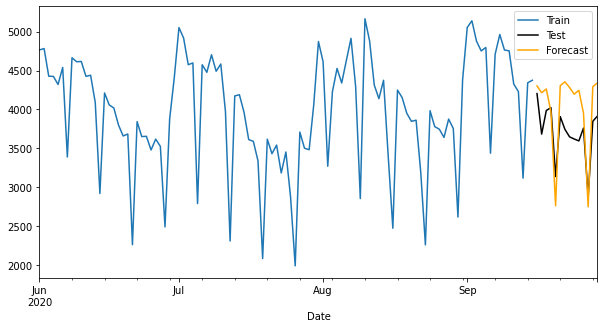

In [26]:
train.plot(kind="line",figsize=(10,5),legend=True, label='Train')
test.plot(kind="line",figsize=(10,5),legend=True, color='black', label='Test')
forecast_2.plot(kind="line",figsize=(10,5),color='orange',legend=True,label='Forecast')
plt.show()

In [27]:
print('RMSE : ', np.sqrt(mean_squared_error(test, forecast_2[0:14])))

RMSE :  433.6462304944543


# Model 3

#### SARIMAX Auto Arima

In [28]:
# Using Auto arima to get the optimized value of p,d,q

from pmdarima import auto_arima

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=1718.144, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=1678.893, Time=0.47 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=1649.920, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=2082.975, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=1706.038, Time=0.17 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=1666.184, Time=1.37 sec
 ARIMA(0,0,1)(0,0,2)[7] intercept   : AIC=1631.162, Time=0.97 sec
 ARIMA(0,0,1)(1,0,2)[7] intercept   : AIC=1642.013, Time=2.16 sec
 ARIMA(0,0,0)(0,0,2)[7] intercept   : AIC=1662.103, Time=0.75 sec
 ARIMA(1,0,1)(0,0,2)[7] intercept   : AIC=1618.214, Time=1.76 sec
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=1645.065, Time=0.45 sec
 ARIMA(1,0,1)(1,0,2)[7] intercept   : AIC=1654.796, Time=3.22 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.65 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=1622.642, Time=1.11 sec
 ARIMA(2,0,1)(0,0,2)[7] intercept   : 

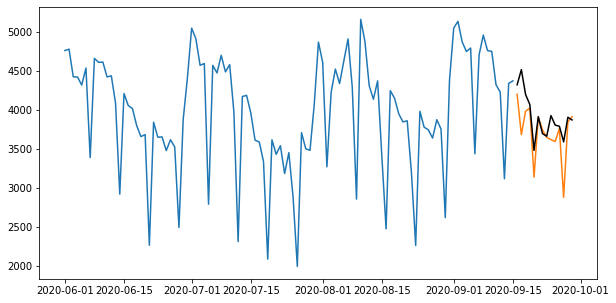

In [29]:
model_3 = auto_arima(train, start_p=0, start_q=0, d=0,
                           max_p=3, max_q=3, m=7,
                           start_P=0, start_Q=0, max_P=2, max_Q=2, seasonal=True,
                           D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True
                          )
model_3.fit(train)

forecast_3 = model_3.predict(n_periods=len(test))
forecast_3 = pd.DataFrame(forecast_3,index = test.index,columns=['Prediction'])

#plot the predictions for validation set

plt.figure(figsize=(10,5))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast_3, label='Prediction', color='black')

plt.show()

In [30]:
print('RMSE : ', np.sqrt(mean_squared_error(test, forecast_3[0:14])))

RMSE :  331.13709934275465


In [31]:
#Dataframe with actual test value and forecasted values of Model 1, Model 2 and Model 3

prediction_df= pd.DataFrame()
prediction_df['Actual_Value']= test
prediction_df['Forecast_1']= forecast_1[0:14].round(2)
prediction_df['Forecast_2']= forecast_2[0:14].round(2)
prediction_df['Forecast_3']= forecast_3.round(2)
prediction_df.tail(7)

,Actual_Value,Forecast_1,Forecast_2,Forecast_3
Date,,,,
2020-09-23,3648.09,3733.24,4281.84,3663.90
2020-09-24,3620.49,3724.25,4196.32,3928.74
2020-09-25,3595.76,3668.45,4245.57,3806.70
2020-09-26,3760.84,3630.89,3952.33,3791.96
2020-09-27,2878.27,3593.75,2748.89,3591.46
2020-09-28,3848.13,3585.22,4292.17,3907.34
2020-09-29,3915.17,3609.54,4342.54,3872.77


# Model 4 
### Using FB Phrophet 